In [1]:
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
class StockProcess:
    def __init__(self):
        self.stock = deque()
        self.total_stock = 0
        self.total_cost = 0
        self.money_cost = 0
        
    def buy(self, price, count):
        self.stock.append((price, count))
        self.total_stock += count
        self.total_cost += price * count
        self.money_cost += price * count + 20
        
    def get_divident(self, divident):
        total = divident * self.total_stock
        self.total_cost -= total
        return total
    
    def get_divident_stock(self, divident):
        total = divident * self.total_stock / 10
        self.total_stock += total
        return total
    
    def avg_cost(self):
        return self.total_cost/self.total_stock
    
    def compute_value(self, stock_price):
        return stock_price * self.total_stock
    
    def return_rate(self, stock_price):
        if self.total_stock:
            return stock_price * self.total_stock / self.money_cost - 1
        return 0

In [3]:
def replace_Q(s):
    # 台灣季報出來時間
    if s[-1] == '1':
        return s[:4] + '-05-15'
    elif s[-1] == '2':
        return s[:4] + '-08-14'
    elif s[-1] == '3':
        return s[:4] + '-11-14'
    else:
        return str(int(s[:4])+1) + '-03-31'
    

In [4]:
def get_est_eps(target, start_date, end_date):
    eps_data = pd.read_html(f'stock_data/{target}_eps.html')[0]
    eps_data = eps_data[:-2]
    eps_data.iloc[:,0] = pd.to_datetime(eps_data[0].map(replace_Q))
    eps_data = eps_data[[0, 9]].set_index(0)
    eps_data.columns = ['EPS']
    eps_data.index.name = 'Date'
    eps_data = eps_data.loc[eps_data.iloc[:, 0] != '-'].astype('float')
    eps_data = eps_data.sort_index()
    eps_data['est_eps'] = 0


    tmp = deque(maxlen=4)
    for d, i in eps_data.iterrows():
        eps = i[0]
        tmp.append(eps)
        eps_data.loc[d, 'est_eps'] = sum(tmp)*4/len(tmp) if len(tmp) < 4 else sum(tmp)     

    data_df = pd.date_range(start=start_date, end=end_date).to_frame()
    data_df['eps'] = 0

    ans, start = 0, 0
    next_data = eps_data.index[0]

    for i in data_df.index:
        if i > next_data:
            ans = eps_data.iloc[start, :]['est_eps']
            start += 1
            if start < len(eps_data.index):
                next_data = eps_data.index[start]
            else:
                next_data = pd.to_datetime('2021-01-01')
        data_df.loc[i, 'eps'] = ans
    data_df = data_df[['eps']]

    return data_df

In [5]:
def get_data(target, pe_limit=100):
    stock_data_file_name = f'stock_data/{target}.TW.csv'
    data_stock = pd.read_csv(stock_data_file_name)
    data_stock['Date'] = pd.to_datetime(data_stock['Date'])

    data_dividend = pd.read_csv(f'stock_data/{target}_dividend.csv')
    if target == '0050':
        data_dividend.iloc[0, 2] = 0.7
    data_dividend['Date'] = pd.to_datetime(data_dividend['Date'])
    data_dividend = data_dividend[['Date', 'Cash Dividend', 'Stock Dividend']]
    data_dividend.columns = ['Date', 'Dividends', 'Stock_div']
    data_dividend = data_dividend[data_stock['Date'].min() < data_dividend['Date']]
    
    # na
    data_stock = data_stock.dropna()
    
    data = data_stock.set_index('Date').join(data_dividend.set_index('Date'), on='Date')
    data['return_rate'] = 0
    
    # add est. eps
    eps = get_est_eps(target, data.index.min(), data.index.max())
    data = data.join(eps, on='Date')
    
    # add PE ratio
    data['pe'] = data['Open'] / data['eps']
    data['pe'] = data['pe'].map(lambda x: x if x >= 0 else -x)
    data['pe'] = data['pe'].map(lambda x: x if x < pe_limit else pe_limit)

    return data

Some rule

In [6]:
# 定時定額
def fix_time_cash(data, start_time, end_time):
    litte_c = StockProcess()
    start_date = pd.to_datetime(start_time)
    end_date = pd.to_datetime(end_time)
    money = 10000
    total_div = 0

    for day, price in data.iterrows():
        if start_date < day <= end_date:
            if not np.isnan(price['Dividends']):
                total_div = litte_c.get_divident(price['Dividends'])
            if not np.isnan(price['Stock_div']):
                litte_c.get_divident_stock(price['Stock_div'])
                
            # 固定星期三 買
            if day.dayofweek == 2:
                buy_price = (price['Open'] + price['Close'])/2
                return_rate = litte_c.return_rate(buy_price)
                buy_count = int(money/buy_price)
                litte_c.buy(buy_price, buy_count)
                
        return_rate = litte_c.return_rate(price['Close'])
        data.loc[day, 'return_rate'] = return_rate
    return data

In [7]:
# 定時固定股數
def fix_time_count(data, start_time, end_time):
    litte_c = StockProcess()
    start_date = pd.to_datetime(start_time)
    end_date = pd.to_datetime(end_time)

    for day, price in data.iterrows():
        if start_date < day <= end_date:
            if not np.isnan(price['Dividends']):
                total_div = litte_c.get_divident(price['Dividends'])
            if not np.isnan(price['Stock_div']):
                litte_c.get_divident_stock(price['Stock_div'])
                
            # 固定星期三 買
            if day.dayofweek == 2:
                buy_price = (price['Open'] + price['Close'])/2
                return_rate = litte_c.return_rate(buy_price)
                buy_count = 100
                litte_c.buy(buy_price, buy_count)
                
        return_rate = litte_c.return_rate(price['Close'])
        data.loc[day, 'return_rate'] = return_rate
    return data

In [8]:
# 定時定額(股利再投入)
def fix_time_cash_add_div(data, start_time, end_time):
    litte_c = StockProcess()
    start_date = pd.to_datetime(start_time)
    end_date = pd.to_datetime(end_time)
    money = 10000
    total_div = 0

    for day, price in data.iterrows():
        if start_date < day <= end_date:
            if not np.isnan(price['Dividends']):
                total_div = litte_c.get_divident(price['Dividends'])
                money += total_div
            if not np.isnan(price['Stock_div']):
                litte_c.get_divident_stock(price['Stock_div'])
                
            # 固定星期三 買
            if day.dayofweek == 2:
                buy_price = (price['Open'] + price['Close'])/2
                return_rate = litte_c.return_rate(buy_price)
                buy_count = int(money/buy_price)
                litte_c.buy(buy_price, buy_count)
                money = 10000
        return_rate = litte_c.return_rate(price['Close'])
        data.loc[day, 'return_rate'] = return_rate
    return data

In [9]:
# 定時定額 且依照報酬率決定投入金額
def fix_time_cash_by_return(data, start_time, end_time, more_para=5):
    litte_c = StockProcess()
    start_date = pd.to_datetime(start_time)
    end_date = pd.to_datetime(end_time)
    money = 10000
    total_div = 0

    for day, price in data.iterrows():
        if start_date < day <= end_date:
            if not np.isnan(price['Dividends']):
                total_div = litte_c.get_divident(price['Dividends'])
            if not np.isnan(price['Stock_div']):
                litte_c.get_divident_stock(price['Stock_div'])
                
            # 固定星期三 買
            if day.dayofweek == 2:
                buy_price = (price['Open'] + price['Close'])/2
                return_rate = litte_c.return_rate(buy_price)
                buy_count = int(money/buy_price)
                if return_rate < 0:
                    buy_count *= 1 + abs(return_rate) * more_para
                litte_c.buy(buy_price, buy_count)

        return_rate = litte_c.return_rate(price['Close'])
        data.loc[day, 'return_rate'] = return_rate
    return data

In [10]:
# 定時定額 且依照報酬率決定投入金額 股利再投入
def fix_time_cash_by_return_add_div(data, start_time, end_time, more_para=5):
    litte_c = StockProcess()
    start_date = pd.to_datetime(start_time)
    end_date = pd.to_datetime(end_time)
    money = 10000
    total_div = 0

    for day, price in data.iterrows():
        if start_date < day <= end_date:
            if not np.isnan(price['Dividends']):
                total_div = litte_c.get_divident(price['Dividends'])
                money += total_div
            if not np.isnan(price['Stock_div']):
                litte_c.get_divident_stock(price['Stock_div'])
                
            # 固定星期三 買
            if day.dayofweek == 2:
                buy_price = (price['Open'] + price['Close'])/2
                return_rate = litte_c.return_rate(buy_price)
                buy_count = int(money/buy_price)
                if return_rate < 0:
                    buy_count *= 1 + abs(return_rate) * more_para
                litte_c.buy(buy_price, buy_count)
                money = 10000
        return_rate = litte_c.return_rate(price['Close'])
        data.loc[day, 'return_rate'] = return_rate
    return data

In [11]:
# 定時定額 且依照 PE ratio 決定投入金額 
def fix_time_cash_by_pe(data, start_time, end_time):
    litte_c = StockProcess()
    start_date = pd.to_datetime(start_time)
    end_date = pd.to_datetime(end_time)
    money = 10000
    total_div = 0

    for day, price in data.iterrows():
        pe_data = data.loc[:day, 'pe'].describe().to_dict()
        if pe_data['count'] <= 100:
            continue
        if start_date < day <= end_date:
            if not np.isnan(price['Dividends']):
                total_div = litte_c.get_divident(price['Dividends'])
            if not np.isnan(price['Stock_div']):
                litte_c.get_divident_stock(price['Stock_div'])
                
            # 固定星期三 買
            if day.dayofweek == 2:
                buy_price = (price['Open'] + price['Close'])/2
                return_rate = litte_c.return_rate(buy_price)
                buy_count = int(money/buy_price)
                if price['pe'] < pe_data['25%']:
                    buy_count *= 3
                elif price['pe'] < pe_data['50%']:
                    buy_count *= 2
                elif price['pe'] < pe_data['75%']:
                    buy_count *= 1
                else:
                    buy_count *= 0
                litte_c.buy(buy_price, buy_count)
        return_rate = litte_c.return_rate(price['Close'])
        data.loc[day, 'return_rate'] = return_rate
    return data

In [12]:
target = '2884'
start, end = '2000-01-01', '2020-10-25'
tmp_df = pd.DataFrame()

ori_data = get_data(target, pe_limit=50)

data = fix_time_count(ori_data.copy(), start, end)
tmp_df['fix_time_count'] = data['return_rate']
tmp_df.index = data.index

data = fix_time_cash(ori_data.copy(), start, end)
tmp_df['fix_time_cash'] = data['return_rate']

data = fix_time_cash_add_div(ori_data.copy(), start, end)
tmp_df['fix_time_cash_add_div'] = data['return_rate']

data = fix_time_cash_by_return(ori_data.copy(), start, end)
tmp_df['fix_time_cash_by_return'] = data['return_rate']

data = fix_time_cash_by_return_add_div(ori_data.copy(), start, end)
tmp_df['fix_time_cash_by_return_add_div'] = data['return_rate']

data = fix_time_cash_by_pe(ori_data.copy(), start, end)
tmp_df['fix_time_cash_by_pe'] = data['return_rate']

tmp_df

,fix_time_count,fix_time_cash,fix_time_cash_add_div,fix_time_cash_by_return,fix_time_cash_by_return_add_div,fix_time_cash_by_pe
Date,,,,,,
2002-01-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2002-01-30,-0.045272,-0.000123,-0.000123,-0.000123,-0.000123,0.000000
2002-01-31,-0.045272,-0.000123,-0.000123,-0.000123,-0.000123,0.000000
2002-02-01,-0.027394,0.018600,0.018600,0.018600,0.018600,0.000000
2002-02-04,-0.016666,0.029835,0.029835,0.029835,0.029835,0.000000
...,...,...,...,...,...,...
2020-10-23,3.505367,5.409816,3.263959,6.096517,3.476624,6.910539
2020-10-26,3.541774,5.461613,3.298415,6.153863,3.512799,6.974463
2020-10-27,3.505367,5.409816,3.263959,6.096517,3.476624,6.910539


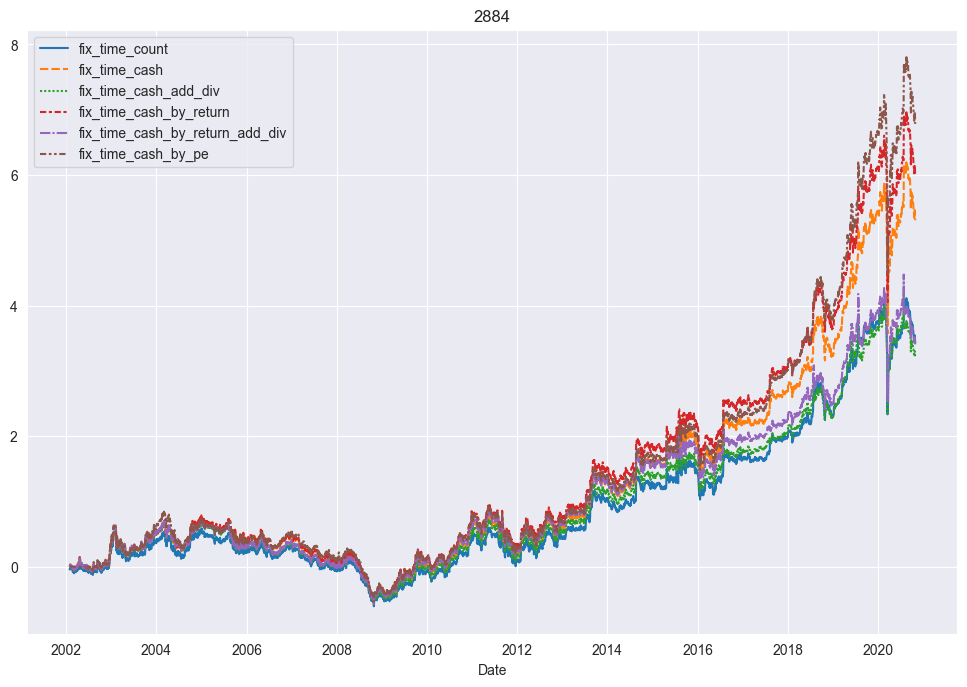

In [13]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 
sns.lineplot(data=tmp_df[tmp_df.sum(axis=1) != 0]).set_title(target)
plt.show()

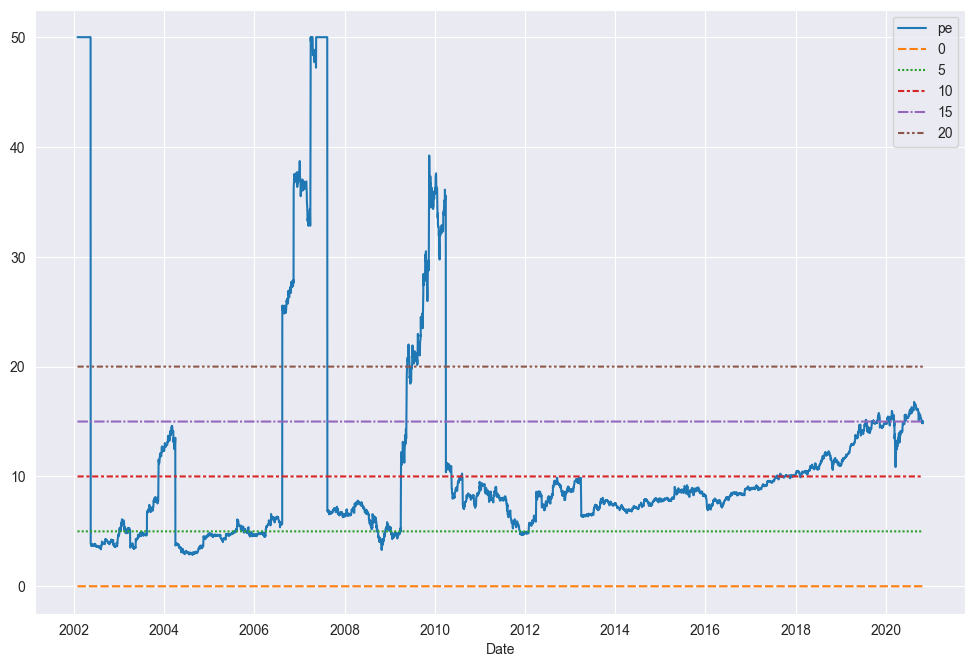

In [14]:
plot_data = data[['pe']].copy()

for i in range(0, 21, 5):
    plot_data[i] = i

sns.lineplot(data=plot_data)

plt.show()